In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import argparse
import os
from glob import glob
import numpy as np
import pandas as pd
from librosa.core import resample, to_mono
from tqdm import tqdm

In [7]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

def downsample_mono(path, sr):
    rate, wav = wavfile.read(path)
    wav = wav.astype(np.float32, order='F')
    try:
        tmp = wav.shape[1]
        wav = to_mono(wav.T)
    except:
        pass
    wav = resample(wav, rate, sr)
    wav = wav.astype(np.int16)
    return sr, wav


def save_sample(sample, rate, target_dir, fn):
    fn = fn.split('.wav')[0]
    dst_path = os.path.join(target_dir.split('.')[0], fn+'.wav')
    if os.path.exists(dst_path):
        return
    wavfile.write(dst_path, rate, sample)


def check_dir(path):
    if os.path.exists(path) is False:
        os.mkdir(path)

def split_wavs(args):
    src_root = args.src_root
    dst_root = args.dst_root
    dt = args.delta_time

    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x for x in wav_paths if '.wav' in x]
    dirs = os.listdir(src_root)
    check_dir(dst_root)
    classes = os.listdir(src_root)
    for _cls in classes:
        target_dir = os.path.join(dst_root, _cls)
        check_dir(target_dir)
        src_dir = os.path.join(src_root, _cls)
        for fn in tqdm(os.listdir(src_dir)):
            src_fn = os.path.join(src_dir, fn)
            rate, wav = downsample_mono(src_fn, args.sr)
            mask, y_mean = envelope(wav, rate, threshold=args.threshold)
            wav = wav[mask]

            save_sample(wav, rate, target_dir, fn)
                    
def test_threshold(args):
    src_root = args.src_root
    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_path = [x for x in wav_paths if args.fn in x]
    if len(wav_path) != 1:
        print('audio file not found for sub-string: {}'.format(args.fn))
        return
    rate, wav = downsample_mono(wav_path[0], args.sr)
    mask, env = envelope(wav, rate, threshold=args.threshold)
    plt.style.use('ggplot')
    plt.title('Signal Envelope, Threshold = {}'.format(str(args.threshold)))
    plt.plot(wav[np.logical_not(mask)], color='r', label='remove')
    plt.plot(wav[mask], color='c', label='keep')
    plt.plot(env, color='m', label='envelope')
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()

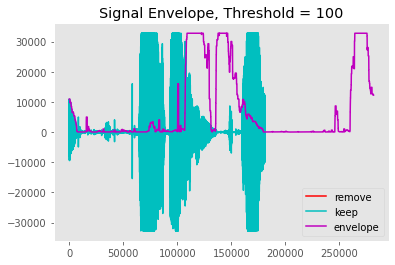

In [16]:
if __name__ == '__main__':
    
    parser = argparse.ArgumentParser(description='Cleaning audio data')
    parser.add_argument('--src_root', type=str, default='data/train',
                        help='directory of audio files in total duration')
    parser.add_argument('--dst_root', type=str, default='data/new',
                        help='directory to put audio files split by delta_time')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sr', type=int, default=16000,
                        help='rate to downsample audio')

    parser.add_argument('--fn', type=str, default='hungry_82',
                        help='file to plot over time to check magnitude')
    parser.add_argument('--threshold', type=str, default=100,
                        help='threshold magnitude for np.int16 dtype')
    args, _ = parser.parse_known_args()

    test_threshold(args)
    #split_wavs(args)

In [15]:
rate, wav = wavfile.read("data/new/awake/awake_10.wav")
length = len(wav)/rate
print(length)

7.4145


In [41]:
rate, t = wavfile.read("data/new/diaper/diaper_21.wav")
print(t.shape[0])
print(len(t))
print(t[5928 : 5928+16000])

113068
113068
[ 151  -74 -193 ...  -74   34   80]
